# Generative Adversarial Networks (GANs)

In this project, I explore the implementation and training of Generative Adversarial Networks (GANs). GANs are a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. They consist of two neural networks, the generator and the discriminator, which compete against each other to create realistic synthetic data.

This project aims to implement a simple GAN and train it to generate images similar to those in the MNIST dataset. The MNIST dataset contains images of handwritten digits and is a common benchmark in the field of machine learning.

## Data Preparation

The first step in our project is to prepare the data. We will use the MNIST dataset, which is a collection of 70,000 handwritten digits commonly used for training various image processing systems.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F


# Setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 100
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

#ToDo: Build the train data loader using the above batch_size variable and shuffling the dataset.
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Model Definition

In this section, we define the architecture for our generator and discriminator networks. The generator takes random noise as input and generates images, while the discriminator attempts to distinguish between real and generated images. The Generator takes as input a Gaussian vector with dimension ```n_dim```. It consists of two linear layers with ```256``` and ```512``` nodes and the output layer should of dimension ```28*28=784``` so that it can be considered as unfolding a ```28*28``` image into a vector. The architecture of the generator and discriminators are kept simple for efficient training with limited resources - naturally, this sacrifices the quality of the generated images. The Discriminator takes as input an image of size ```28*28```. It consists of two linear layers with ```512``` and ```256``` nodes and the output layer is a single node.

In [5]:
class Generator(nn.Module):
    def __init__(self, n_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(n_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1) # Making sure that the batch of images has the shape [batch_size,28*28] instead of [batch_size,1,28,28]

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

## Training the GAN

Next, we define the optimizers and loss function. Then, we train the GAN using a combination of the generator and discriminator losses. The generator aims to fool the discriminator by generating realistic images, while the discriminator aims to correctly identify real and generated images.

In [6]:
n_dim = 100
generator = Generator(n_dim).to(device)
discriminator = Discriminator().to(device)
lr = 0.0002

criterion = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

num_epochs = 100
total_step = len(data_loader)
real_scores = []
fake_scores = []
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        real_images = images.to(device)

        # Training discriminator
        discriminator.zero_grad()

        # Compute loss with real images
        real_outputs = discriminator(real_images)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        d_loss_real = criterion(real_outputs, real_labels)

        # Compute loss with fake images
        noise = torch.randn(batch_size, n_dim).to(device)  # n_dim is the dimensionality of the input noise vector for the generator
        fake_images = generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_outputs = discriminator(fake_images.detach())  # Detach to avoid training generator on these labels
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Training generator
        generator.zero_grad()

        #ToDo: compute g_loss
        # Compute loss with fake images but flip labels to trick the discriminator
        fake_outputs = discriminator(fake_images)  # No detach() here because we want to train the generator
        target_labels = torch.ones(batch_size, 1).to(device)  # Try to fool the discriminator
        g_loss = criterion(fake_outputs, target_labels)

        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 300 == 0:
            # After updating the discriminator
            real_score = torch.mean(real_outputs).item()
            fake_score = torch.mean(fake_outputs.detach()).item()  # Use detach() to not affect gradients

            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}, '
                  f'Real Score: {real_score:.4f}, Fake Score: {fake_score:.4f}')

    # EXTRA
    # Save the models
    if (epoch % 10 == 0):
        torch.save(generator.state_dict(), "./etc/generator")
        torch.save(discriminator.state_dict(), "./etc/discriminator")

Epoch [1/100], Step [300/600], Discriminator Loss: 0.2444, Generator Loss: 4.3924, Real Score: 0.9120, Fake Score: 0.0144
Epoch [1/100], Step [600/600], Discriminator Loss: 0.0818, Generator Loss: 4.6962, Real Score: 0.9859, Fake Score: 0.0124
Epoch [2/100], Step [300/600], Discriminator Loss: 0.2217, Generator Loss: 3.3963, Real Score: 0.9178, Fake Score: 0.0429
Epoch [2/100], Step [600/600], Discriminator Loss: 0.6254, Generator Loss: 2.2953, Real Score: 0.8808, Fake Score: 0.1212
Epoch [3/100], Step [300/600], Discriminator Loss: 0.3794, Generator Loss: 2.7233, Real Score: 0.8643, Fake Score: 0.0734
Epoch [3/100], Step [600/600], Discriminator Loss: 0.2377, Generator Loss: 3.8539, Real Score: 0.9403, Fake Score: 0.0319
Epoch [4/100], Step [300/600], Discriminator Loss: 0.2314, Generator Loss: 3.1529, Real Score: 0.9334, Fake Score: 0.0971
Epoch [4/100], Step [600/600], Discriminator Loss: 0.4365, Generator Loss: 4.3912, Real Score: 0.8302, Fake Score: 0.0396
Epoch [5/100], Step [300

## Results and Observations

After training the GAN, we analyze the results by generating images and observing the training loss over epochs. The pictures do resemble handwritten digits as expected!

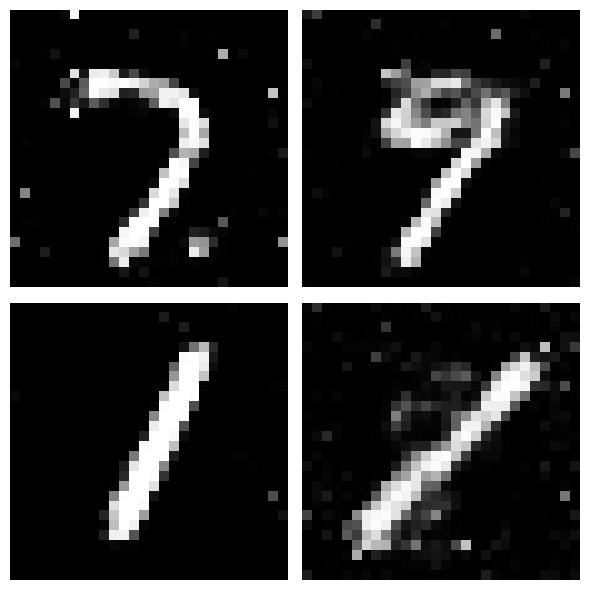

In [7]:
# Generate 4 random noise vectors
z = torch.randn(batch_size, n_dim).to(device)

# Generate images
with torch.no_grad():  # We don't need to track gradients here
    generator.eval()  # Ensure the generator is in eval mode
    fake_images = generator(z)

# Assuming the generated images are 1x28x28 (for grayscale)
# Adjust the code below if your image dimensions are different

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
for i, ax in enumerate(axs.flat):
    # The output from the generator will have the shape [Batch_size, Channels, Height, Width]
    # Here we reshape it to [Height, Width] for matplotlib
    img = fake_images[i].cpu().reshape(28, 28)  # Adjust for your dimensions
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # Turn off axis numbering

plt.tight_layout()
plt.show()